# Analysis of the determinants of Super Rugby

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from openpyxl import load_workbook
import xlrd

In [7]:
PATH = 'opta_stats/'

In [8]:
# create a list of all files to be parsed
file_list = os.listdir(PATH)

## Applying code to every file to create dataframe prior to processing data

In [9]:
# Create data frame to store data
workbook = xlrd.open_workbook(PATH + file_list[0], on_demand=True)

# Load match stats for workbook
match_stats = workbook.sheet_by_name('MatchStats')

# enumerate column headings to prevent empty and repeated headings
df_column_list = [(i,cell.value) for i, cell in enumerate(match_stats.col(10))]
match_stats_df = pd.DataFrame(columns=df_column_list)

In [10]:
file_list = os.listdir(PATH)

for file in file_list:
    
    # Load selected workbook
    workbook = xlrd.open_workbook(PATH + file, on_demand=True)
    
    # Load match stats for workbook
    match_stats = workbook.sheet_by_name('MatchStats')
    
    # Create row for home stats
    home_stats = [cell.value for cell in match_stats.col(11)]
    home_stats = pd.DataFrame(home_stats, index=df_column_list)
    
    # Create row for away_stats
    away_stats = [cell.value for cell in match_stats.col(18)]
    away_stats = pd.DataFrame(away_stats, index=df_column_list)
    
    # Append home and away stats to main df
    match_stats_df = match_stats_df.append([home_stats.T, away_stats.T])

In [6]:
# Drop all th emepty columns
match_stats_df = match_stats_df.drop([(0, ''), (1, 'Team Comparison'), (2, ''), (20, ''), (21, ''),
                                     (29, ''), (30, ''), (31, ''), (39, ''), (40, ''), (41, ''),
                                     (49, '')], axis=1)

In [7]:
# Create better column names
col_names = list(match_stats_df.columns)
new_columns = [col[1] for col in col_names]
renamed_cols = {}
for old, new in zip(col_names, new_columns):
    renamed_cols[old] = new
    
match_stats_df.rename(columns=renamed_cols, inplace=True)
match_stats_df.reset_index(inplace=True)
match_stats_df.drop('index', axis=1, inplace=True)

match_stats_df.columns = ['Tries','Conversions', 'Penalty Goal', 
                          'Carries', 'Offloads', 'Clean Breaks', 
                          'Defenders Beaten', 'Metres', 'Tackles', 
                          'Missed Tackles', 'Turnovers Won', 'Turnovers Con', 
                          'LO Throws Won','LO Throws Lost', 'Penalties Offence', 
                          'Penalties Defence','Kicks in Play', 'ff_Carries',
                          'ff_Metres', 'ff_Tackles', 'ff_Missed Tackles','ff_Offloads',
                          'ff_Defenders Beaten', 'ff_Penalties Con', 'br_Carries', 
                          'br_Metres','br_Tackles', 'br_Missed Tackles', 'br_Offloads',
                          'br_Defenders Beaten','br_Penalties Con', 'back_Carries', 
                          'back_Metres', 'back_Tackles', 'back_Missed Tackles','back_Offloads', 
                          'back_Defenders Beaten', 'back_Penalties Con']

In [8]:
# Create column of home and away diff
match_stats_df.loc[match_stats_df.index % 2 == 1, 'home_away'] = 0
match_stats_df.loc[match_stats_df.index % 2 == 0, 'home_away'] = 1
home_away = {'home':1, 'away':0}

In [9]:
# Create the new variable columns
match_stats_df['points'] = match_stats_df['Tries']*5 + match_stats_df['Penalty Goal']*3 + match_stats_df['Conversions']*2
match_stats_df['ave_carry'] = match_stats_df['Carries']/match_stats_df['Metres']
match_stats_df['ff_ave_carry'] = match_stats_df['ff_Carries'] / match_stats_df['ff_Metres']
match_stats_df['br_ave_carry'] = match_stats_df['br_Carries'] / match_stats_df['br_Metres']
match_stats_df['back_ave_carry'] = match_stats_df['back_Carries'] / match_stats_df['back_Metres']
match_stats_df['tackle_ratio'] = match_stats_df['Tackles']/ match_stats_df['Missed Tackles']
# match_stats_df['ff_tackle_ratio'] = match_stats_df['ff_Tackles'] / match_stats_df['ff_Missed Tackles']
# match_stats_df['br_tackle_ratio'] = match_stats_df['br_Tackles'] / match_stats_df['br_Missed Tackles']
# match_stats_df['back_tackle_ratio'] = match_stats_df['back_Tackles'] / match_stats_df['back_Missed Tackles']


In [10]:
# convert match stats df to float
for col in match_stats_df.columns:
    match_stats_df[col] = pd.to_numeric(match_stats_df[col])
    
match_stats_df.fillna(0, inplace=True)
home_rel = match_stats_df[::2]
away_rel = match_stats_df[1::2]

In [11]:
win_loss_rel_home = home_rel.reset_index() - away_rel.reset_index()

In [12]:
# win loss rel home is all home differences, we need to create opposite dataframe for away diff
win_loss_rel_away = win_loss_rel_home * -1

In [13]:
# Join home and away rel df for final df
win_loss_rel = pd.concat([win_loss_rel_home, win_loss_rel_away], ignore_index=True)

In [14]:
# Add win/loss column
win_loss_rel.loc[win_loss_rel['points'] > 0, 'win'] = 1
win_loss_rel.loc[win_loss_rel['points'] < 0, 'win'] = 0


In [15]:
# Delete any draws
draws = win_loss_rel[win_loss_rel['points'] == 0].index
win_loss_rel.drop(draws, inplace=True)

## Random Forest Classifier

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz

In [17]:
# Create features and lables
features = win_loss_rel.loc[:,['Carries', 'Offloads',
       'Clean Breaks', 'Defenders Beaten', 'Metres', 'Tackles',
       'Missed Tackles', 'Turnovers Won', 'Turnovers Con', 'LO Throws Won',
       'LO Throws Lost', 'Penalties Offence', 'Penalties Defence',
       'Kicks in Play', 'ff_Carries', 'ff_Metres', 'ff_Tackles',
       'ff_Missed Tackles', 'ff_Offloads', 'ff_Defenders Beaten',
       'ff_Penalties Con', 'br_Carries', 'br_Metres', 'br_Tackles',
       'br_Missed Tackles', 'br_Offloads', 'br_Defenders Beaten',
       'br_Penalties Con', 'back_Carries', 'back_Metres', 'back_Tackles',
       'back_Missed Tackles', 'back_Offloads', 'back_Defenders Beaten',
       'back_Penalties Con', 'ave_carry',
       'ff_ave_carry', 'br_ave_carry', 'back_ave_carry', 'tackle_ratio']]

features_col = features.columns

labels = win_loss_rel['win']

In [18]:
# convert to np array for random forest
features = np.array(features)
labels = np.array(labels)

In [28]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2)

In [29]:
# Create Random forest classifier
RF_classifier = RandomForestClassifier(max_depth=5)

In [30]:
RF_classifier.fit(features_train, labels_train)

/home/grantbeasley/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [31]:
RF_classifier.feature_importances_

array([0.01020592, 0.00465402, 0.10134881, 0.06397735, 0.02462013,
       0.00200741, 0.02619679, 0.03175616, 0.01399362, 0.00398307,
       0.0028311 , 0.02820547, 0.02179983, 0.21591293, 0.00290178,
       0.02801943, 0.00226743, 0.00167284, 0.0100849 , 0.        ,
       0.        , 0.01010246, 0.01173067, 0.00030461, 0.00355743,
       0.00261482, 0.01634962, 0.00766082, 0.01049269, 0.11150665,
       0.03280095, 0.0145615 , 0.00507078, 0.0281538 , 0.00376785,
       0.03012819, 0.02729397, 0.00770724, 0.04747941, 0.03227755])

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25]),
 <a list of 6 Text xticklabel objects>)

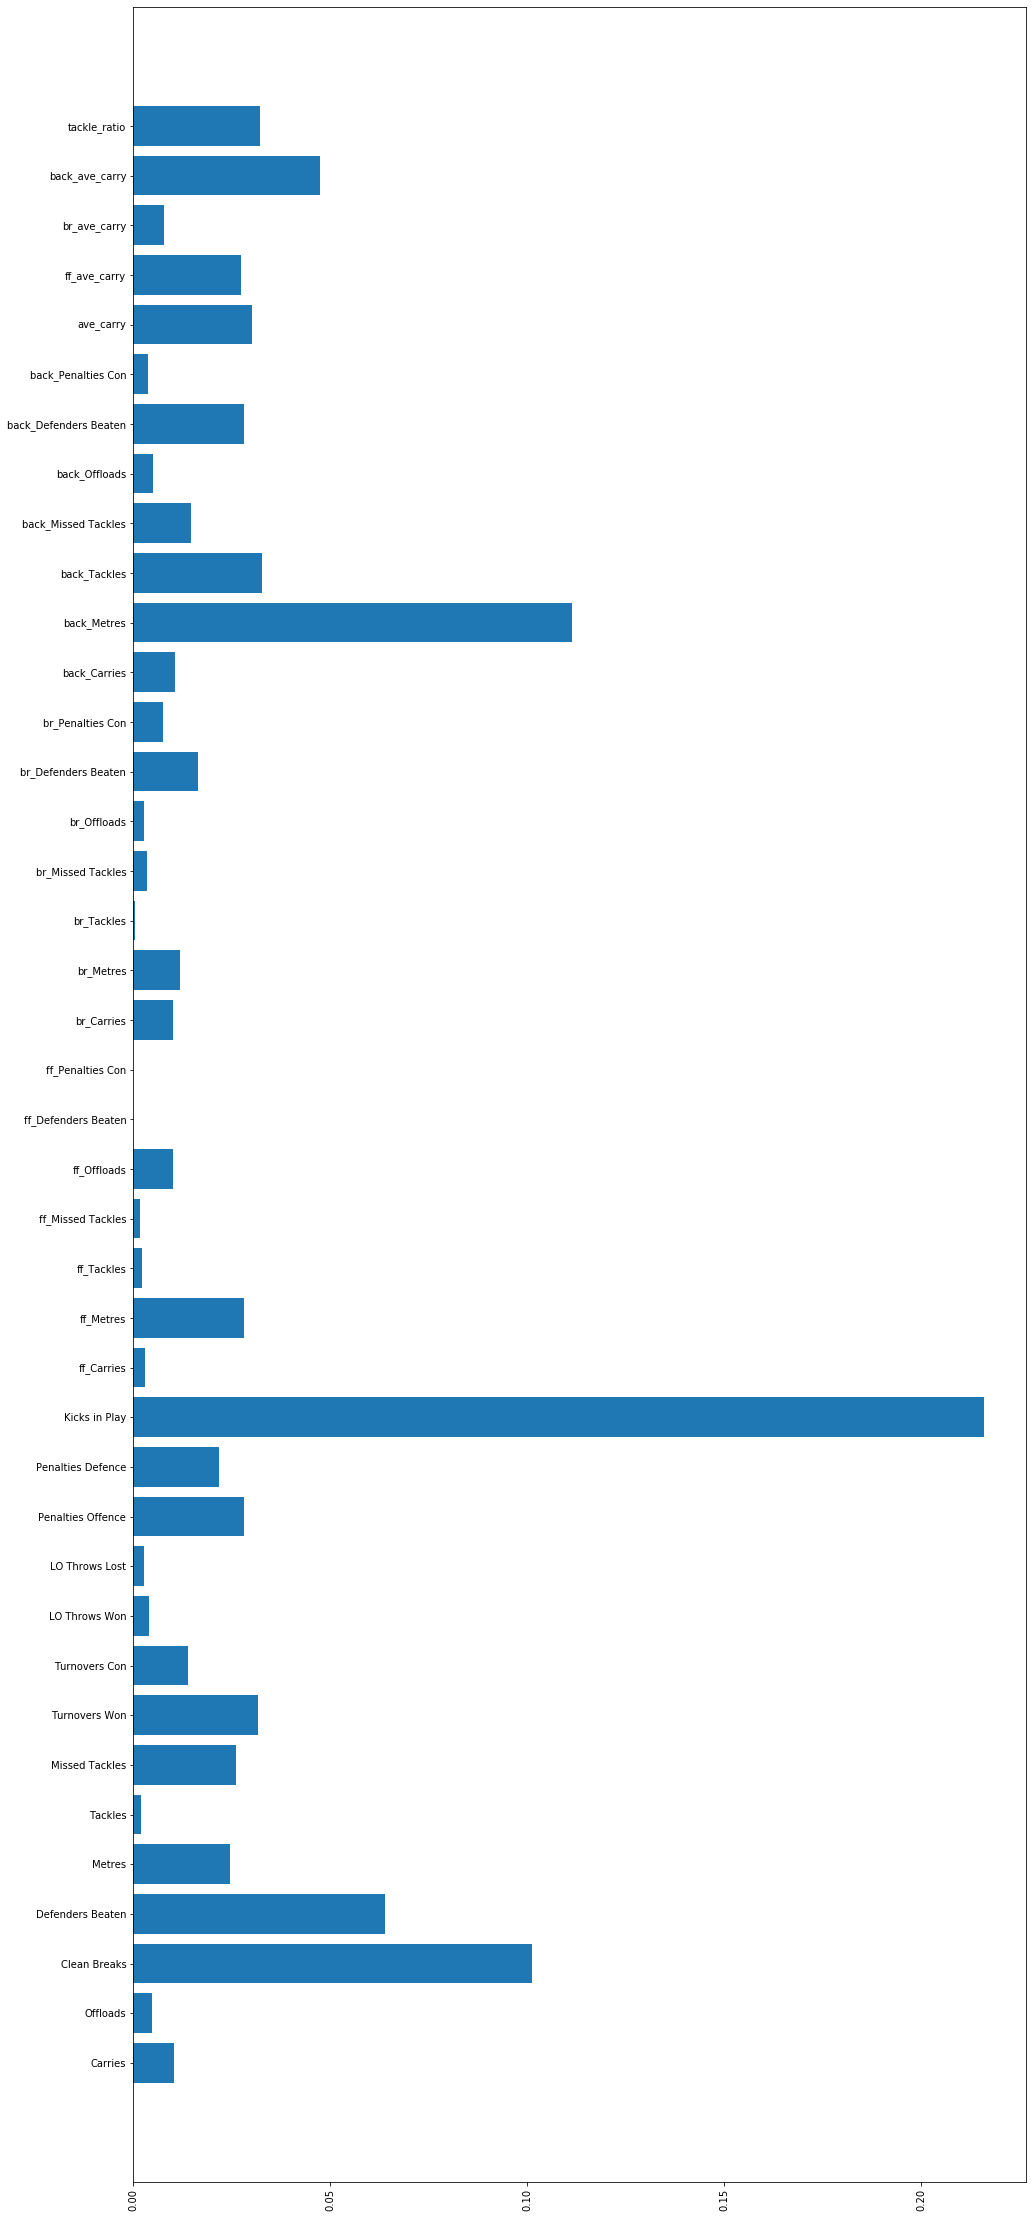

In [32]:
plt.figure(figsize=(16,40))
plt.barh(features_col, RF_classifier.feature_importances_,)
plt.xticks(rotation=90)

In [33]:
labels_test

array([0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.])

In [34]:
RF_classifier.decision_path(features_train)

(<192x328 sparse matrix of type '<class 'numpy.int64'>'
 	with 10770 stored elements in Compressed Sparse Row format>,
 array([  0,  23,  60,  95, 124, 159, 206, 235, 266, 299, 328]))

In [35]:
RF_classifier.score(features_test, labels_test)

0.7291666666666666

In [27]:
export_graphviz(RF_classifier.estimators_[0], out_file='rf.dot',
                feature_names=features_col,
                filled=True,
                rounded=True)

from subprocess import call
call(['dot','-Tpng','rf.dot', '-o', 'rf.png', '-Gdpi=600'])

0

## Running RF mulitple times and averaging results

In [36]:
array_list = []
for i in range(100):
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2)
    RF_classifier.fit(features_train, labels_train)
    array_list.append(RF_classifier.feature_importances_)
    

In [37]:
array_list

[array([0.02254036, 0.01149327, 0.06253579, 0.00895739, 0.03112687,
        0.02937721, 0.02277469, 0.04307853, 0.03687   , 0.00580937,
        0.        , 0.02880513, 0.0094764 , 0.17003235, 0.00882471,
        0.01937718, 0.02016821, 0.00506332, 0.00856152, 0.01367948,
        0.00354154, 0.01001933, 0.01435198, 0.00737995, 0.02466776,
        0.02059115, 0.0048095 , 0.01459836, 0.00168264, 0.04110201,
        0.01667959, 0.04854222, 0.01269546, 0.00859065, 0.00605583,
        0.06997899, 0.02988451, 0.0079994 , 0.03770194, 0.06057541]),
 array([0.00972527, 0.00075356, 0.03504761, 0.03032271, 0.04590644,
        0.0121213 , 0.02689637, 0.04806377, 0.0313122 , 0.00818995,
        0.00074238, 0.01704394, 0.00526338, 0.17578156, 0.00376455,
        0.02784046, 0.01820369, 0.00611395, 0.00988894, 0.00251817,
        0.        , 0.00402998, 0.00707138, 0.04366756, 0.00433701,
        0.0051376 , 0.02882354, 0.00089255, 0.03556108, 0.07611759,
        0.04024973, 0.01105073, 0.00500803, 0.

In [43]:
test = np.mean(np.array([array_list]), axis=1)

In [49]:
test

array([[0.01473089, 0.01015528, 0.09334901, 0.01956183, 0.03581345,
        0.0179597 , 0.02068411, 0.03985447, 0.0386835 , 0.01103727,
        0.00830478, 0.02228926, 0.01082121, 0.12534938, 0.01071387,
        0.01602837, 0.01784346, 0.0097926 , 0.01128091, 0.0100979 ,
        0.01065498, 0.01629145, 0.01106956, 0.01730793, 0.00809687,
        0.00962655, 0.01431467, 0.00825683, 0.01534573, 0.04688819,
        0.02291987, 0.03476151, 0.0108382 , 0.01312008, 0.01039956,
        0.05629999, 0.02824641, 0.01445804, 0.06058956, 0.04616274]])

(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14]),
 <a list of 8 Text xticklabel objects>)

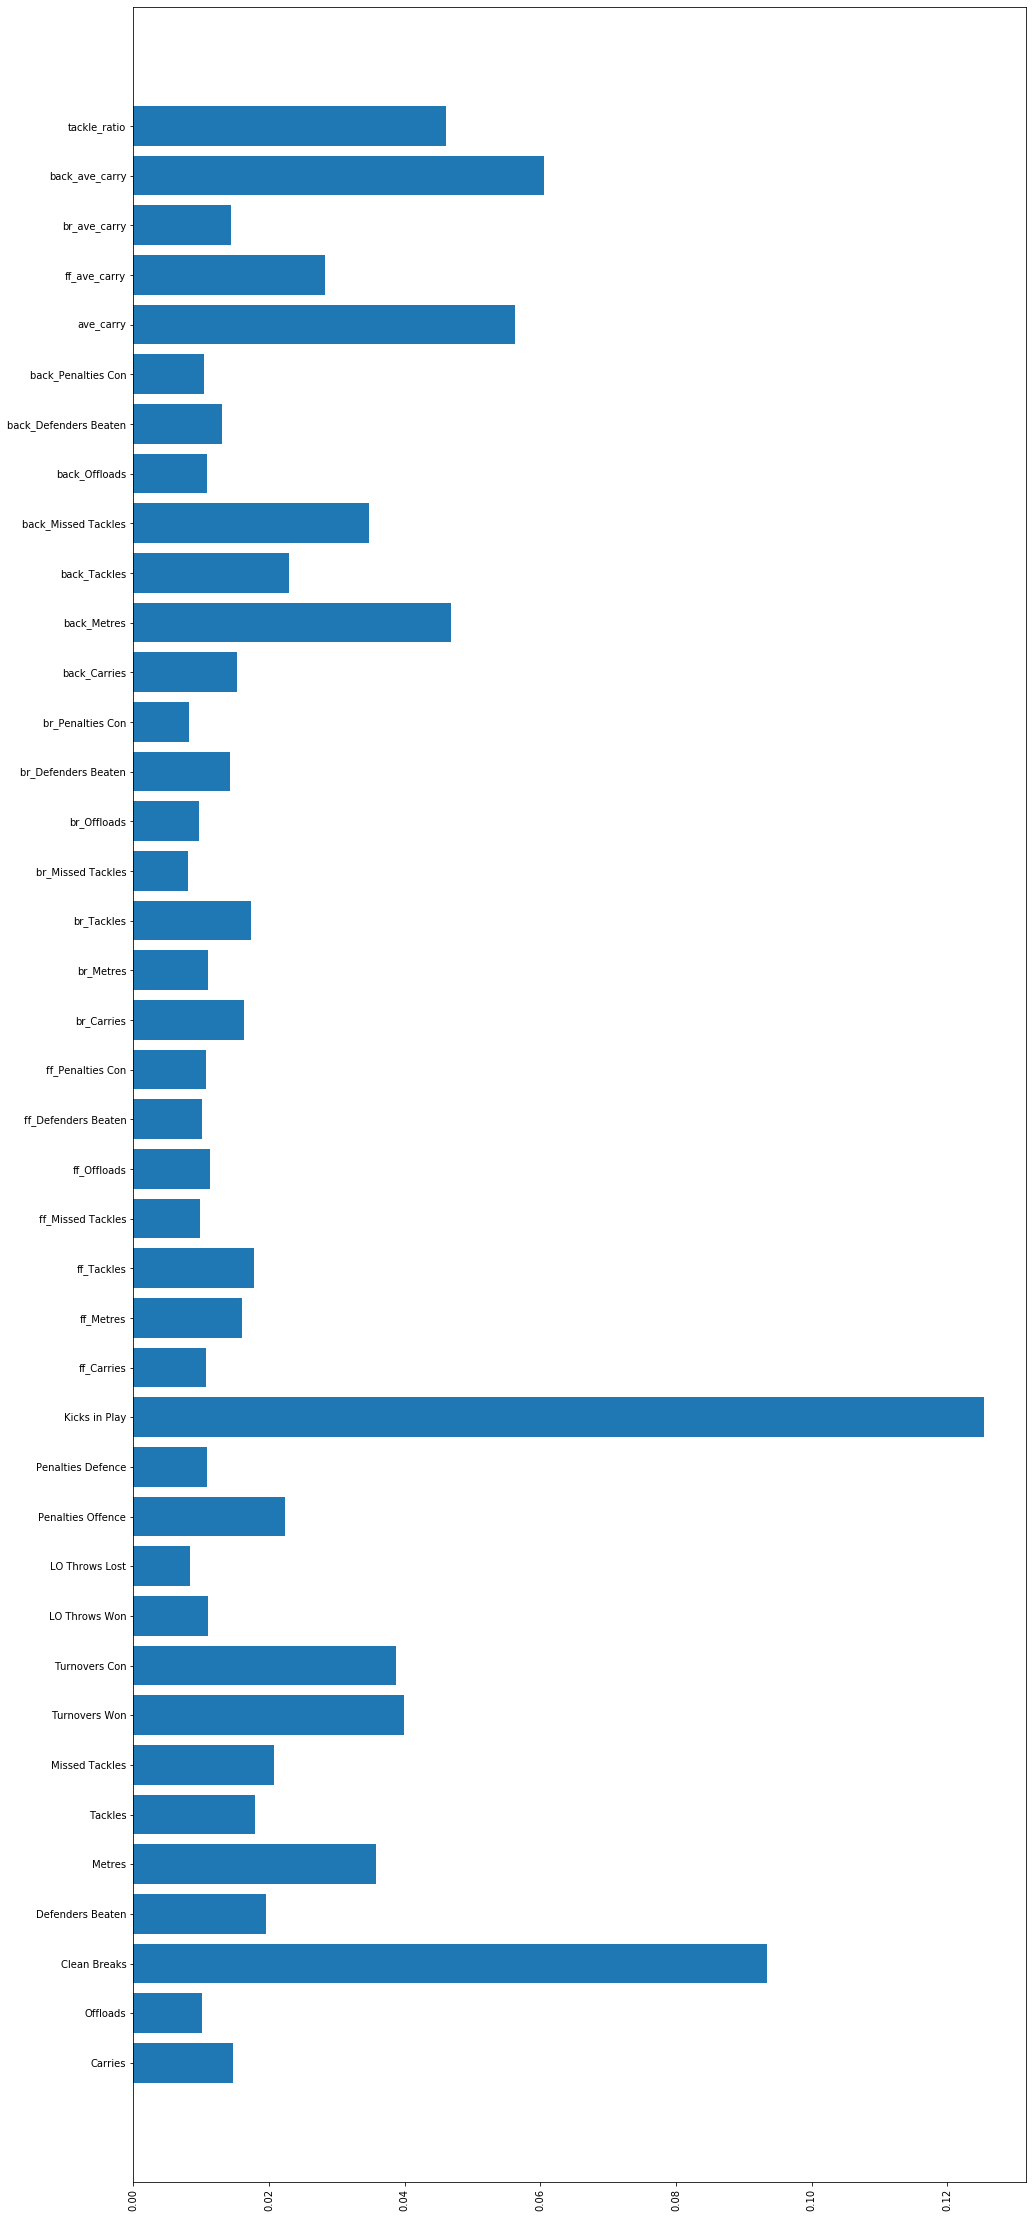

In [47]:
plt.figure(figsize=(16,40))
plt.barh(features_col, test[0])
plt.xticks(rotation=90)